# Generate SVS NIfTI MRS example manually
Data is taken from a single subject's STEAM SVS scan on a Siemens VB platform 7T.

In [1]:
%load_ext autoreload
%autoreload 2
from mapvbvd import mapVBVD
from pathlib import Path
import numpy as np
import h5py
import datetime
import json
import nibabel as nib
import matplotlib.pyplot as plt

### Load the data
Data is in the Siemens 'raw' Twix (.dat) format. There is a water suppressed and water unsuppressed data set.

In [2]:
supressed_file = Path('../original_data/meas_MID310_STEAM_metab_FID115673.dat')
unsupressed_file = Path('../original_data/meas_MID312_STEAM_wref3_FID115675.dat')

suppressed_raw = mapVBVD(supressed_file,quiet=True)
unsuppressed_raw = mapVBVD(unsupressed_file,quiet=True)

### Extract data
Extract the blocks of data and pad with three spatial dimension.  
We expect 4096 points, 32 coils and multiple averages.

In [3]:
suppressed_raw.image.removeOS=False
unsuppressed_raw.image.removeOS=False
supp_block = suppressed_raw.image.unsorted()
unsupp_block = unsuppressed_raw.image.unsorted()

newshape = (1,1,1)+supp_block.shape
supp_block = supp_block.reshape(newshape)

newshape = (1,1,1)+unsupp_block.shape
unsupp_block = unsupp_block.reshape(newshape)

print(unsupp_block.shape)

(1, 1, 1, 4096, 32, 2)


Plot the unsupressed data from a single coil and dynamic

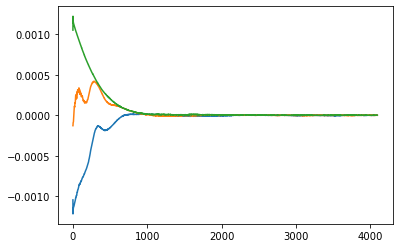

In [4]:
plt.plot(np.real(unsupp_block[0,0,0,:,0,0]))
plt.plot(np.imag(unsupp_block[0,0,0,:,0,0]))
plt.plot(np.abs(unsupp_block[0,0,0,:,0,0]))
plt.show()

### Voxel orientation calculations 
Use spec2nii's specific twix implementation

In [5]:
from spec2nii.twixfunctions import twix2DCMOrientation,examineTwix,extractTwixMetadata
from spec2nii.dcm2niiOrientation.orientationFuncs import nifti_dicom2mat
from spec2nii.nifti_orientation import NIFTIOrient

# Orientation calculations
#1) Calculate dicom like imageOrientationPatient,imagePositionPatient,pixelSpacing and slicethickness
imageOrientationPatient,imagePositionPatient,pixelSpacing,slicethickness = twix2DCMOrientation(suppressed_raw['hdr'],False)

# 2) in style of dcm2niix
# a) calculate Q44
xyzMM = np.append(pixelSpacing,slicethickness)
Q44 = nifti_dicom2mat(imageOrientationPatient,imagePositionPatient,xyzMM,verbose=False)
# b) calculate nifti quaternion parameters
Q44[:2,:] *= -1
# 3) place in data class for nifti orientation parameters  
currNiftiOrientation = NIFTIOrient(Q44)

print(currNiftiOrientation.Q44)

[[ 20.          -0.          -0.         -32.90067836]
 [ -0.         -20.          -0.          10.6633755 ]
 [  0.           0.         -20.          21.35589036]
 [  0.           0.           0.           1.        ]]


### Meta data
Now manually assemble the meta-data
#### Dimension information

In [6]:
dim_dict = {'dim_5': 'DIM_COIL',
            'dim_6': 'DIM_DYN',
            'dim_6_use': 'Signal repetitions'}

#### Required for Minimum conformance
**SpectrometerFrequency** , Array of doubles, See DICOM tag (0018,9098). Should be given in MHz.  
**ResonantNucleus**, Array of strings, See DICOM tag (0018,9100). Must be one of the DICOM recognised nuclei “1H”, “3HE”, “7LI”, “13C”, “19F”, “23NA”, “31P”, “129XE” or one named in the specified format. I.e. Mass number followed by the chemical symbol in uppercase.  

__Stored in pixdim[4]__  
**Dwelltime**, Should be given in s.  

In [7]:
dwelltime = suppressed_raw['hdr']['MeasYaps'][('sRXSPEC','alDwellTime','0')]/1E9 # For nifti pixel dim
transmitter_frequency_mhz = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'lFrequency')]/1E6
nucleus_str = suppressed_raw['hdr']['MeasYaps'][('sTXSPEC', 'asNucleusInfo', '0', 'tNucleus')].strip('"')

print(f'SpectrometerFrequency = {transmitter_frequency_mhz:0.6f} MHz')
print(f'ResonantNucleus = {nucleus_str}')
print(f'dwelltime = {dwelltime:0.2e} s')


SpectrometerFrequency = 297.219948 MHz
ResonantNucleus = 1H
dwelltime = 8.33e-05 s


#### Extract some optional standard-defined metadata as well 

Incude:  
**EchoTime**, double, Time from centroid of excitation to start of FID or centre of echo. Units: Seconds  
**RepetitionTime**, double, Sequence repetition time. Units: Seconds  
**InversionTime**, double, Inversion time. Units: Seconds  
**MixingTime**, double, Mixing time in e.g. STEAM sequence. Units: Seconds


**ConversionMethod**, String, Program used for conversion. May include additional information like software version.  
**ConversionTime**, String:  “YYYY-MM-DDThh:mm:ss.sss”, Time and date of conversion. ISO 8601 compliant format  
**OriginalFile**, String, Name and extension of the original file  

In [8]:
echo_time_s = suppressed_raw['hdr']['MeasYaps'][('alTE', '0')]/1E6
repetition_time_s = suppressed_raw['hdr']['MeasYaps'][('alTR', '0')]/1E6
inversion_time_s = None
mixing_time_s = suppressed_raw['hdr']['MeasYaps'][('alTD', '0')]/1E6

print(f'EchoTime = {echo_time_s:0.3f} s')
print(f'RepetitionTime = {repetition_time_s:0.3f} s')
print(f'InversionTime = {inversion_time_s} s')
print(f'MixingTime = {mixing_time_s:0.3f} s')

conversion_method = 'Manual'
conversion_time = datetime.datetime.now().isoformat(sep='T',timespec='milliseconds')
original_file = [str(supressed_file.name)]

print(f'ConversionMethod = {conversion_method}')
print(f'ConversionTime = {conversion_time}')
print(f'OriginalFile = {original_file}')

EchoTime = 0.011 s
RepetitionTime = 5.000 s
InversionTime = None s
MixingTime = 0.032 s
ConversionMethod = Manual
ConversionTime = 2020-12-16T15:16:41.062
OriginalFile = ['meas_MID310_STEAM_metab_FID115673.dat']


#### Add some user-defined meta-data
Store sequence binary names for easy identification.  
The information must be in a fixed structure with a 'Description' field.

In [9]:
siemens_sequence_info = {'Description': 'Paths to sequence and reconstruction code binaries for sequence identification.',
                         'sequence': suppressed_raw['hdr']['Config'][('SequenceFileName')],
                         'recon': suppressed_raw['hdr']['Meas'][('tICEProgramName')]}

## Make the json string
Use Python's inbuilt json library to convert a dict into the header extension string.  
We will create an example with minimal conformance and with extra information.

In [10]:
metadata_dict_required = {**dim_dict,
                          'TransmitterFrequency':transmitter_frequency_mhz,
                          'ResonantNucleus':nucleus_str}

json_min = json.dumps(metadata_dict_required)
print(json_min)

metadata_dict = {**metadata_dict_required,
                'EchoTime':echo_time_s,
                'RepetitionTime':repetition_time_s,
                'InversionTime':inversion_time_s,
                'MixingTime':mixing_time_s,
                'ConversionMethod':conversion_method,
                'ConversionTime': conversion_time,
                'OriginalFile': original_file,
                'siemens_sequence_info': siemens_sequence_info}

json_full= json.dumps(metadata_dict)
print(json_full)


{"dim_5": "DIM_COIL", "dim_6": "DIM_DYN", "dim_6_use": "Signal repetitions", "TransmitterFrequency": 297.219948, "ResonantNucleus": "1H"}
{"dim_5": "DIM_COIL", "dim_6": "DIM_DYN", "dim_6_use": "Signal repetitions", "TransmitterFrequency": 297.219948, "ResonantNucleus": "1H", "EchoTime": 0.011, "RepetitionTime": 5.0, "InversionTime": null, "MixingTime": 0.032, "ConversionMethod": "Manual", "ConversionTime": "2020-12-16T15:16:41.062", "OriginalFile": ["meas_MID310_STEAM_metab_FID115673.dat"], "siemens_sequence_info": {"Description": "Paths to sequence and reconstruction code binaries for sequence identification.", "sequence": "%CustomerSeq%\\uzay_steam_gui", "recon": "%CustomerIceProgs%\\uzayIcePrgSpecOnline"}}


## Data conventions
Ensure that this data conforms to the phase/frequency conventions.
- The spectral data points are ordered in sequence of increasing time and contain the value TIME.
- In a right-handed coordinate system (x corresponding to real values, y imaginary values, and z time):  
    - data arising from nuclei with a positive gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a positive (counter-clockwise) rotation.
    - data arising from nuclei with a negative gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a negative (clockwise) rotation.  
    
It doesn't so the first thing we do is conjugate.

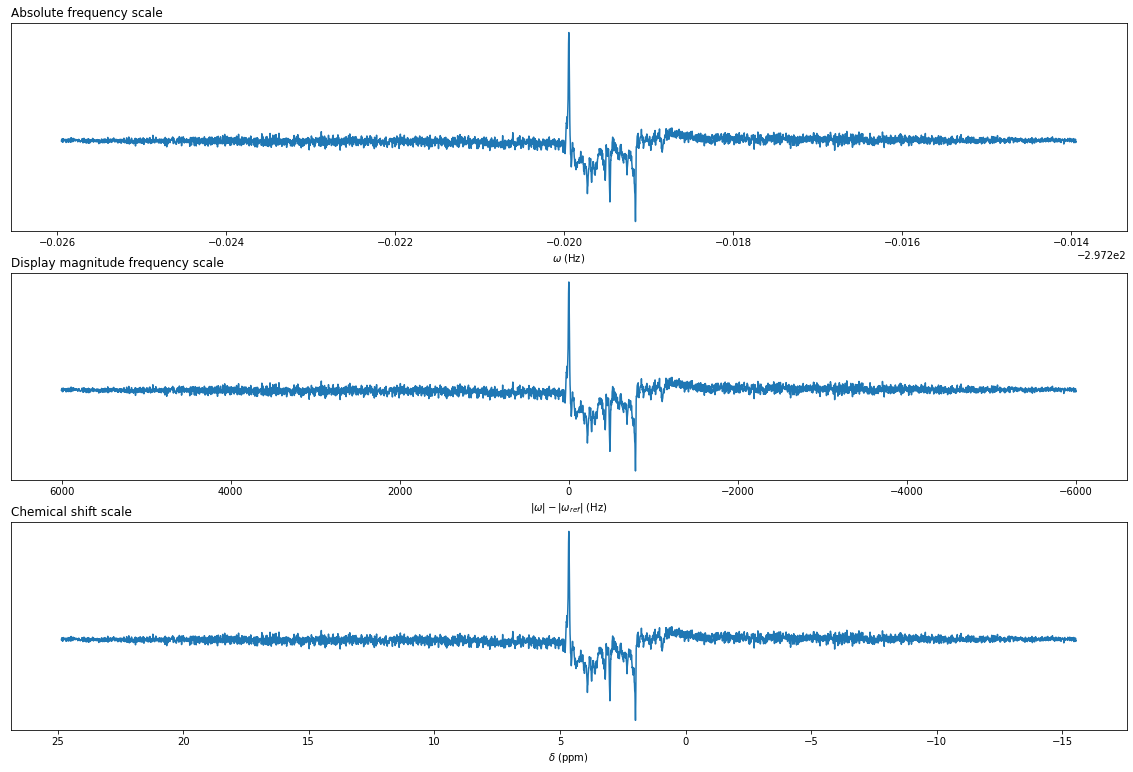

In [11]:
supp_block = supp_block.conj()
unsupp_block = unsupp_block.conj()

# Make absolute frequency scale (remember the -ve sign in omega=-gamma.B0)
spectral_width_hz = 1/dwelltime
npoints = supp_block.shape[3]
frequency_axis = np.linspace(-spectral_width_hz/2,spectral_width_hz/2,npoints) 
abs_freq_axis = -transmitter_frequency_mhz + frequency_axis/1E6
# Display frequency axis
frequency_axis *= -1
# Chemical shift axis (shifted to TMS)
c_shift_axis = 4.65+ frequency_axis/transmitter_frequency_mhz

test_FID = np.mean(supp_block[0,0,0,:,0,:],axis=1)

spec_fft = np.fft.fftshift(np.fft.fft(test_FID))

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
ax1.plot(abs_freq_axis,np.real(spec_fft))
ax1.set_yticks([])
ax1.set_xlabel('$\omega$ (Hz)')
ax1.set_title('Absolute frequency scale',loc='left')

ax2.plot(frequency_axis,np.real(spec_fft))
ax2.set_yticks([])
ax2.invert_xaxis()
ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
ax2.set_title('Display magnitude frequency scale',loc='left')

ax3.plot(c_shift_axis,np.real(spec_fft))
ax3.set_yticks([])
ax3.invert_xaxis()
ax3.set_xlabel('$\delta$ (ppm)')
ax3.set_title('Chemical shift scale',loc='left')

plt.show()

## Write the NIfTI file 
Using the NIfTI-2 format as recommended (but not required) by the specification.

In [12]:
save_path = Path('../example_data/svs_1')

newobj = nib.nifti2.Nifti2Image(supp_block,currNiftiOrientation.Q44)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set version information 
newobj.header['intent_name'] = b'mrs_v0_2'

# Write extension with ecode 44
extension = nib.nifti1.Nifti1Extension(44, json_full.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,save_path / 'svs_suppressed.nii.gz')

### Repeat for minimum conformance 

In [13]:
newobj = nib.nifti2.Nifti2Image(supp_block,currNiftiOrientation.Q44)

pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set version information 
newobj.header['intent_name'] = b'mrs_v0_2'

# Write extension with ecode 44
extension = nib.nifti1.Nifti1Extension(44, json_min.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,save_path / 'svs_suppressed_min.nii.gz')

### And unsuppressed

In [14]:
newobj = nib.nifti2.Nifti2Image(unsupp_block,currNiftiOrientation.Q44)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set version information 
newobj.header['intent_name'] = b'mrs_v0_2'

# Write extension with ecode 44
extension = nib.nifti1.Nifti1Extension(44, json_full.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,save_path / 'svs_unsuppressed.nii.gz')

## Write a version of this data which has been combined.
Here we use data from fsl_mrs's example data which is in a 'plain' NIfTI format.

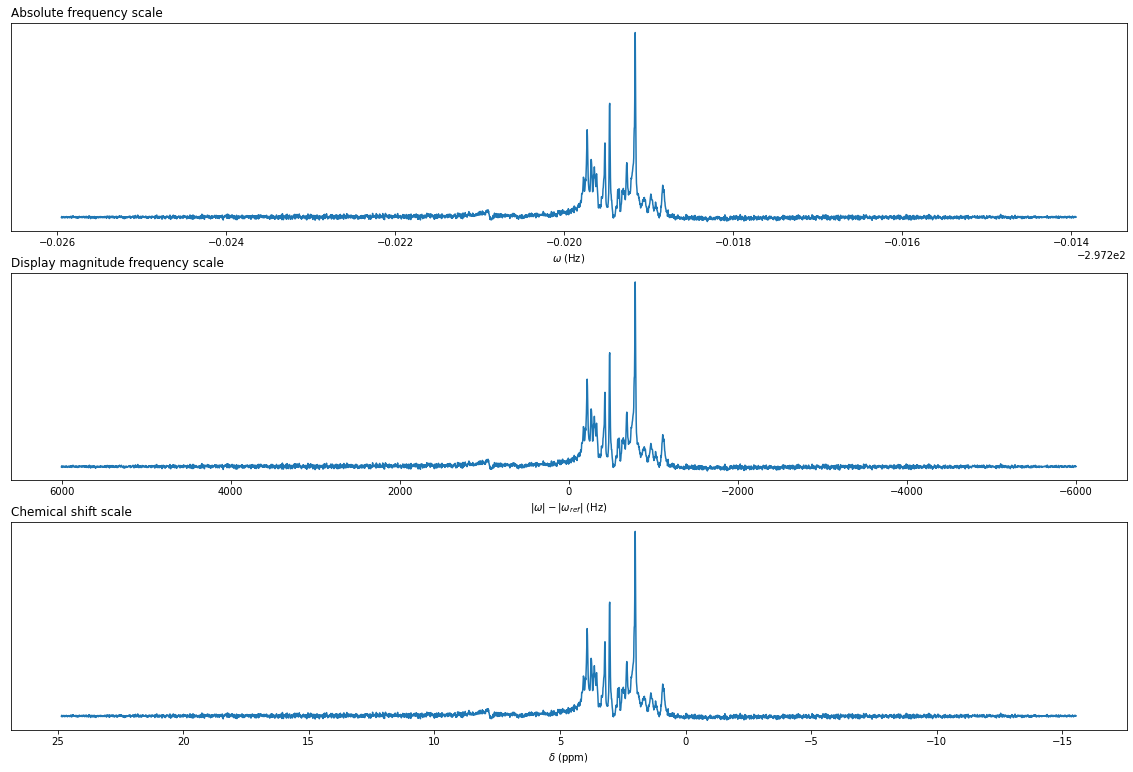

In [15]:
combined_data = nib.load('../original_data/metab.nii')
combined_data_values = combined_data.get_fdata(dtype=np.complex64)
combined_data_values = combined_data_values.conj()
combined_data_values = np.pad(combined_data_values,((0,0),(0,0),(0,0),(0,1))) # Zero pad to correct odd number of points

spec_fft = np.fft.fftshift(np.fft.fft(combined_data_values[0,0,0,:]))

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
ax1.plot(abs_freq_axis,np.real(spec_fft))
ax1.set_yticks([])
ax1.set_xlabel('$\omega$ (Hz)')
ax1.set_title('Absolute frequency scale',loc='left')

ax2.plot(frequency_axis,np.real(spec_fft))
ax2.set_yticks([])
ax2.invert_xaxis()
ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
ax2.set_title('Display magnitude frequency scale',loc='left')

ax3.plot(c_shift_axis,np.real(spec_fft))
ax3.set_yticks([])
ax3.invert_xaxis()
ax3.set_xlabel('$\delta$ (ppm)')
ax3.set_title('Chemical shift scale',loc='left')

plt.show()

combined_data_out = nib.nifti2.Nifti2Image(combined_data_values,currNiftiOrientation.Q44)

pixDim = combined_data_out.header['pixdim']
pixDim[4] = dwelltime
combined_data_out.header['pixdim'] = pixDim

# Set q_form >0
combined_data_out.header.set_qform(currNiftiOrientation.Q44)

min_dict_preproc = {'SpectrometerFrequency':transmitter_frequency_mhz,
                    'ResonantNucleus':nucleus_str}

dict_preproc = {**min_dict_preproc,
                'EchoTime':echo_time_s,
                'RepetitionTime':repetition_time_s,
                'InversionTime':inversion_time_s,
                'MixingTime':mixing_time_s,
                'ConversionMethod':conversion_method,
                'ConversionTime': conversion_time,
                'OriginalFile': original_file}

json_preproc = json.dumps(dict_preproc)

# Set conformance level 
combined_data_out.header['intent_name'] = b'mrs_v0_2'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, json_preproc.encode('UTF-8'))
combined_data_out.header.extensions.append(extension)

# # From nii obj and write    
nib.save(combined_data_out,save_path / 'svs_preprocessed.nii.gz')

### Save out hdf5 versions of data
This is done to validate any loader against.

In [16]:
with h5py.File(save_path / 'data.h5', 'w') as h5f:
    h5f.create_dataset('svs_suppressed', data=supp_block)
    h5f.create_dataset('svs_suppressed_min', data=supp_block)
    h5f.create_dataset('svs_unsuppressed', data=unsupp_block)
    h5f.create_dataset('svs_preprocessed', data=combined_data_values)

## Load and check what we have written
Python nibabel library works both ways!

In [17]:
check_nifti = nib.load(save_path / 'svs_suppressed.nii.gz')

with h5py.File(save_path / 'data.h5','r') as h5f:
    check_hdf5 = h5f['svs_suppressed'][:]
    
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64),supp_block)
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64),check_hdf5)

loaded_he_content = json.loads(check_nifti.header.extensions[0].get_content())

assert loaded_he_content == metadata_dict
